In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [2]:
df = pd.read_csv("data.csv")
df.head()

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


In [3]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [4]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16)
        )
        self.mu = nn.Linear(16, latent_dim)
        self.log_var = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, input_dim)
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        enc = self.encoder(x)
        mu, log_var = self.mu(enc), self.log_var(enc)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def sample(self, n_samples):
        with torch.no_grad():
            z = torch.randn(n_samples, latent_dim)
            return self.decoder(z).numpy()

Epoch 0, Loss: 2.6666
Epoch 50, Loss: 0.9873
Epoch 99, Loss: 0.8599
Epoch 0, Loss: 1.2488
Epoch 50, Loss: 0.8185
Epoch 99, Loss: 0.7470
Epoch 0, Loss: 1.5281
Epoch 50, Loss: 0.8447
Epoch 99, Loss: 0.7154
Epoch 0, Loss: 1.4743
Epoch 50, Loss: 0.8092
Epoch 99, Loss: 0.6939


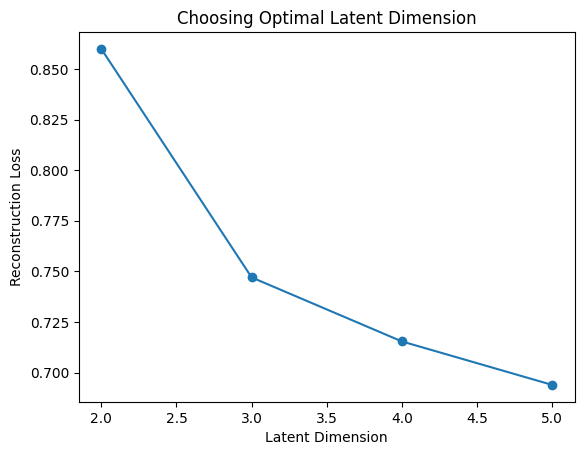

In [5]:
latent_dims = [2, 3, 4, 5]  
reconstruction_losses = []
epochs_num = 100

for latent_dim in latent_dims:
    vae = VAE(input_dim=data_scaled.shape[1], latent_dim=latent_dim)  
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    # optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    # loss_fn = nn.SmoothL1Loss()

    for epoch in range(epochs_num):  
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        beta = min(0.1 + 0.01 * epoch, 0.5)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta * kl_loss
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0 or epoch==epochs_num-1:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    reconstruction_losses.append(loss.item())

plt.plot(latent_dims, reconstruction_losses, marker='o', linestyle='-')
plt.xlabel("Latent Dimension")
plt.ylabel("Reconstruction Loss")
plt.title("Choosing Optimal Latent Dimension")
plt.show()


In [6]:
# Training VAE
input_dim = data_scaled.shape[1]
latent_dim = 5  # From checking, I got 4 to be the better latent dimension.
vae = VAE(input_dim, latent_dim)
# optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
# loss_fn = nn.SmoothL1Loss()
loss_fn = nn.MSELoss()

In [7]:
def train_vae(epochs=epochs_num):
    vae.train()
    for epoch in range(epochs):
        x = torch.tensor(data_scaled, dtype=torch.float32)
        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        recon_loss = loss_fn(x_recon, x)
        beta = min(0.1 + 0.01 * epoch, 0.5)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + 0.1 * kl_loss 
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [8]:
train_vae(epochs=200)

Epoch 0, Loss: 1.5231
Epoch 10, Loss: 1.0088
Epoch 20, Loss: 0.9160
Epoch 30, Loss: 0.8115
Epoch 40, Loss: 0.7507
Epoch 50, Loss: 0.6898
Epoch 60, Loss: 0.6395
Epoch 70, Loss: 0.5803
Epoch 80, Loss: 0.5462
Epoch 90, Loss: 0.5067
Epoch 100, Loss: 0.4924
Epoch 110, Loss: 0.4704
Epoch 120, Loss: 0.4535
Epoch 130, Loss: 0.4376
Epoch 140, Loss: 0.4183
Epoch 150, Loss: 0.4166
Epoch 160, Loss: 0.4016
Epoch 170, Loss: 0.3962
Epoch 180, Loss: 0.3819
Epoch 190, Loss: 0.3677
Epoch 199, Loss: 0.3682


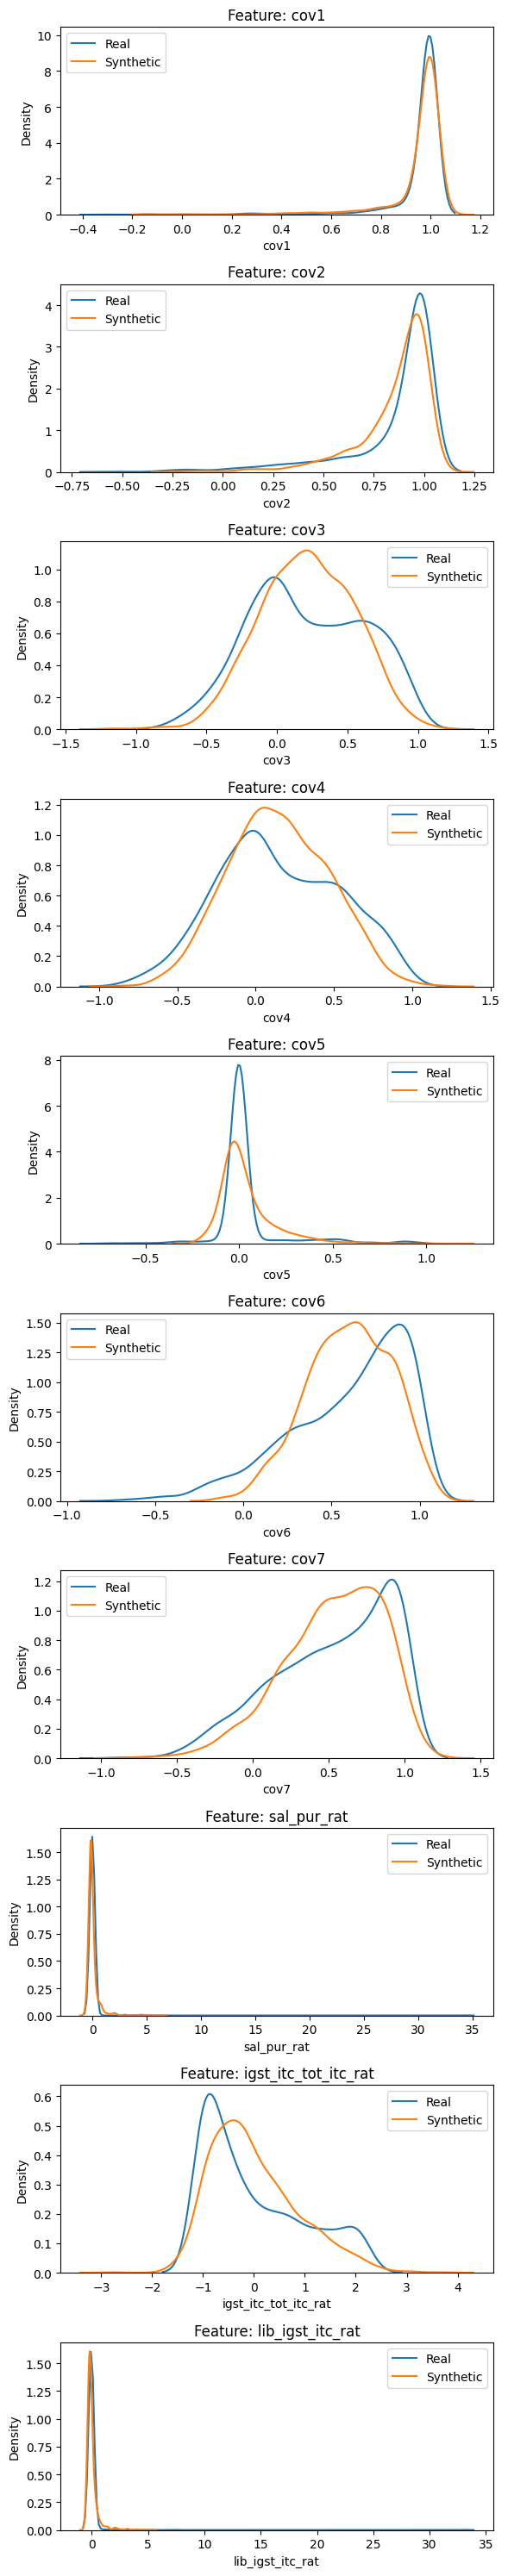

In [9]:
# Generate synthetic dataset
synthetic_data = vae.sample(n_samples=len(df))

# Inverse transform synthetic data back to the original feature scale
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# --- Plot Feature Distributions ---
num_features = df.shape[1]
fig, axes = plt.subplots(nrows=num_features, figsize=(6, num_features * 3))

for i, column in enumerate(df.columns):
    sns.kdeplot(df[column], label="Real", ax=axes[i])
    sns.kdeplot(synthetic_df[column], label="Synthetic", ax=axes[i])
    axes[i].set_title(f"Feature: {column}")
    axes[i].legend()

plt.tight_layout()
plt.show()

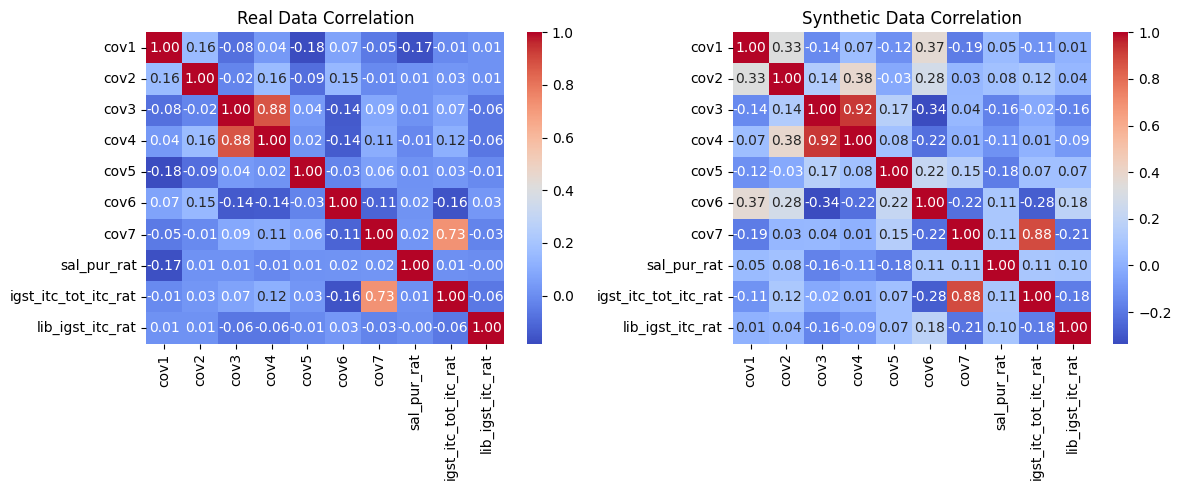

In [10]:
# --- Compute and Plot Correlation Heatmaps ---
real_corr = df.corr()
synthetic_corr = synthetic_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", annot=True, fmt=".2f")
axes[0].set_title("Real Data Correlation")

sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", annot=True, fmt=".2f")
axes[1].set_title("Synthetic Data Correlation")

plt.tight_layout()
plt.show()

In [11]:
# Get Latent Representations
vae.eval()
x = torch.tensor(data_scaled, dtype=torch.float32)
_, mu, _ = vae(x)
latent_data = mu.detach().numpy()

In [12]:
# Elbow Method to Determine k
from kneed import KneeLocator

inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(latent_data)
    inertia.append(kmeans.inertia_)

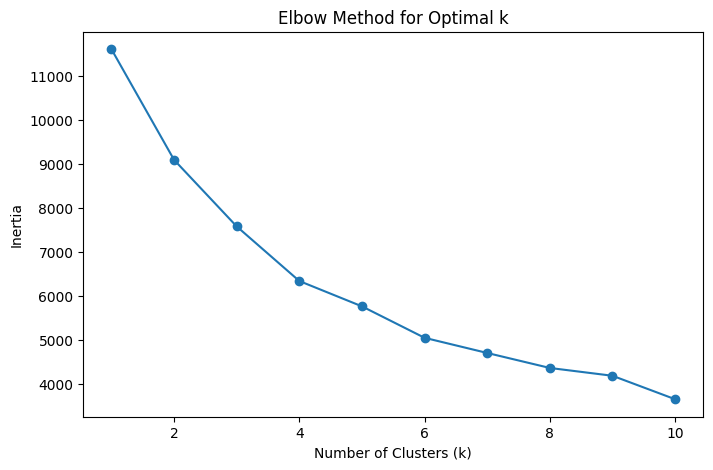

Optimal k found: 4


In [13]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

knee_locator = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k found: {optimal_k}")

In [14]:
# Apply K-Means
# optimal_k = 4  # From above checking, I got 3 to be the better number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(latent_data)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [15]:
# Identifying the outliers:
# Small clusters have been considered as those which have their size less than 50.
# For big clusters, we have taken boundary points as those which are outside 95% away from the cluster's center.

clusters, counts = np.unique(labels, return_counts=True)

print("Cluster Sizes:")
for cluster, count in zip(clusters, counts):
    print(f"Cluster {cluster}: {count} points")

small_clusters = clusters[counts < 50]

boundary_points = []
small_cluster_points = []

for i, label in enumerate(labels):
    if label in small_clusters:
        small_cluster_points.append(i)  
    else:
        point_dist = np.linalg.norm(latent_data[i] - cluster_centers[label])
        all_dists = np.linalg.norm(latent_data[labels == label] - cluster_centers[label], axis=1)
        
        # Boundary points: Points which are outside 95% of the distance
        if point_dist > np.percentile(all_dists, 95):
            boundary_points.append(i)  

print("Boundary Points Row Numbers:", boundary_points)
print("Small Cluster Points Row Numbers:", small_cluster_points)

Cluster Sizes:
Cluster 0: 336 points
Cluster 1: 342 points
Cluster 2: 386 points
Cluster 3: 135 points
Boundary Points Row Numbers: [30, 32, 42, 64, 66, 74, 82, 102, 106, 115, 136, 138, 154, 177, 188, 197, 202, 209, 219, 225, 249, 251, 258, 261, 278, 288, 302, 308, 314, 365, 404, 406, 435, 455, 462, 492, 495, 496, 527, 547, 561, 591, 668, 678, 697, 719, 747, 778, 821, 859, 870, 881, 887, 943, 952, 986, 996, 1009, 1010, 1018, 1141, 1150]
Small Cluster Points Row Numbers: []
